# FP Growth algorithm implementation and visualization

This notebook provides a simple demo of implementing FP-Growth algorithm in python using the "pyfpgrowth" library.  
It shows the patterns that gets generated on the sample data as well as the rules that are obtained using the generated patterns.  
Also, a visualization exercise to represent the obtained rules.

In [1]:
import pyfpgrowth
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
data = pd.read_excel('data/Online_Retail.xlsx', sheet_name='Sheet1')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID
0,536365,1,pizza_dough,3,50,cust_1
1,536365,2,cheeze,2,40,cust_1
2,536365,5,oregano,1,20,cust_1
3,536366,6,salty_snack,5,40,cust_2
4,536366,8,beer,4,100,cust_2


### Frequency plot for each of the items in the dataset

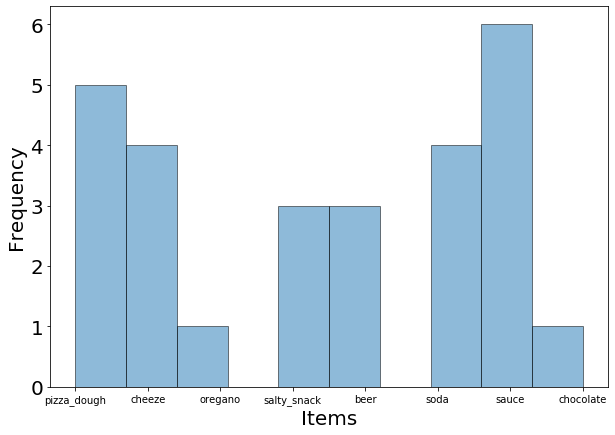

In [4]:
# Plot frequency of each item in the dataset

plt.figure(figsize = (10, 7)) 
plt.xlabel('Items', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.hist(data['Description'], bins = 10, alpha = 0.5, histtype = 'bar', ec = 'black')
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 20) 
plt.show() 

In [5]:
# Create transactions for each of the InvoiceNo.

grouped_df = data.groupby(by = ['InvoiceNo'])

transactions = []
for group, pdf in grouped_df:
    transactions.append(pdf['Description'].tolist())
    
transactions

[['pizza_dough', 'cheeze', 'oregano'],
 ['salty_snack', 'beer', 'soda'],
 ['cheeze', 'sauce'],
 ['chocolate', 'beer', 'salty_snack', 'soda'],
 ['pizza_dough', 'sauce'],
 ['salty_snack', 'sauce'],
 ['pizza_dough', 'sauce'],
 ['pizza_dough', 'cheeze', 'sauce', 'soda'],
 ['pizza_dough', 'cheeze', 'sauce'],
 ['soda', 'beer']]

### Generate patterns

In [6]:
# Find the frequent patterns with support_threshold of 2

patterns = pyfpgrowth.find_frequent_patterns(transactions, 2)
patterns

{('salty_snack',): 3,
 ('salty_snack', 'soda'): 2,
 ('beer',): 3,
 ('beer', 'soda'): 3,
 ('cheeze', 'pizza_dough'): 3,
 ('cheeze', 'sauce'): 3,
 ('cheeze', 'pizza_dough', 'sauce'): 2,
 ('soda',): 4,
 ('pizza_dough',): 5,
 ('pizza_dough', 'sauce'): 4,
 ('sauce',): 6}

### Generate association rules

In [7]:
# Generate association rules with confidence_threshold of 0.7

rules = pyfpgrowth.generate_association_rules(patterns, 0.5)
rules

{('salty_snack',): (('soda',), 0.6666666666666666),
 ('soda',): (('beer',), 0.75),
 ('beer',): (('soda',), 1.0),
 ('pizza_dough',): (('sauce',), 0.8),
 ('sauce',): (('pizza_dough',), 0.6666666666666666),
 ('cheeze', 'pizza_dough'): (('sauce',), 0.6666666666666666),
 ('cheeze', 'sauce'): (('pizza_dough',), 0.6666666666666666),
 ('pizza_dough', 'sauce'): (('cheeze',), 0.5)}

#### Observation

It can be seen from the generated rules that  

The probability of buying "soda" given that "beer" is already bought is 100%.  
However, the probability of buying "beer" given that "soda" is already bought is 75%.

Similarly, the probability of buying "sauce" given that "pizza_dough" is already bought is 80%.

### Visualization of Rules

In [8]:
# Create a dictionary representing the source and target edges with its confidence score as weights

src_dest_wght = {}

for key, val in rules.items():
    if len(key) > 1:
        for k in key:
            if src_dest_wght.get((k, val[0][0])):
                old_val = src_dest_wght[(k, val[0][0])]
                src_dest_wght[(k, val[0][0])] = old_val if old_val > round(val[1], 2) else round(val[1], 2)
            else:
                src_dest_wght[(k, val[0][0])] = round(val[1], 2)
    else:                
        src_dest_wght[(key[0], val[0][0])] = round(val[1], 2)
        
src_dest_wght

{('salty_snack', 'soda'): 0.67,
 ('soda', 'beer'): 0.75,
 ('beer', 'soda'): 1.0,
 ('pizza_dough', 'sauce'): 0.8,
 ('sauce', 'pizza_dough'): 0.67,
 ('cheeze', 'sauce'): 0.67,
 ('cheeze', 'pizza_dough'): 0.67,
 ('pizza_dough', 'cheeze'): 0.5,
 ('sauce', 'cheeze'): 0.5}

In [9]:
# Create a dictionary of {item:support_count}

item_count = data.groupby(by = ['Description']).size().reset_index(name = 'support_count')
item_supp = dict(zip(item_count['Description'], item_count['support_count']))

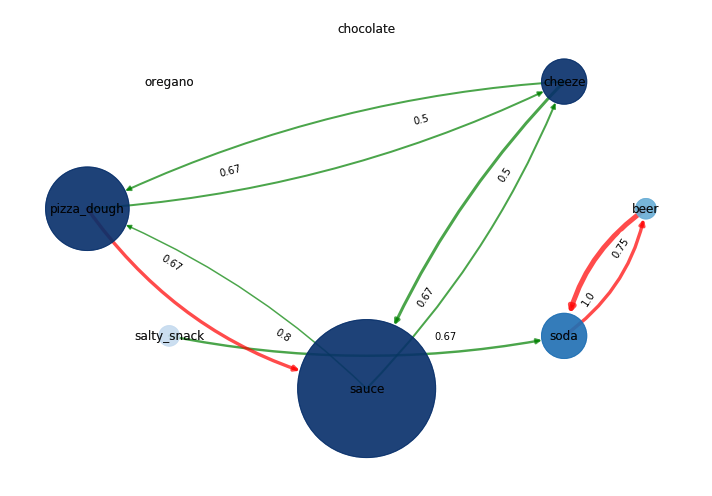

In [10]:
plt.figure(figsize =(10, 7)) 

# Define a directed graph
G = nx.DiGraph()

# Add all the item nodes
for key in item_supp.keys():
    G.add_node(key)

# Set support_count attribute for all the nodes
for i in list(G.nodes()): 
    G.nodes[i]['support_count'] = item_supp[i]
     
# Size of node is a list of support_count
node_size = [nx.get_node_attributes(G, 'support_count')[v] ** 5.5 for v in G] 
    
# Add edges to the graph vased on the rules
for key, val in src_dest_wght.items():
    G.add_edge(key[0], key[1], weight = val)

# Node colour is a list of degrees of nodes 
node_color = [G.degree(v) for v in G] 

# Segregate edges based on the support_threshold value of 0.7
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.7]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.7]

# Width of edge is a list of weight of edges
elarge_width = [5 * G[u][v]['weight'] for u, v in G.edges()] 
esmall_width = [3 * G[u][v]['weight'] for u, v in G.edges()] 

# Define the graph layout
pos = nx.circular_layout(G)    

# Draw small edges with support_count <= 0.7
nx.draw_networkx(G, pos, edgelist = esmall, node_size = node_size, node_color = node_color, alpha = 0.7, 
                 with_labels = True, width = esmall_width, edge_color ='g', cmap = plt.cm.Blues, 
                 connectionstyle='arc3, rad = 0.1')

# Draw large edges with support_count > 0.7
nx.draw_networkx(G, pos, edgelist = elarge, node_size = node_size, node_color = node_color, alpha = 0.7, 
                 with_labels = True, width = elarge_width, edge_color ='r', cmap = plt.cm.Blues, 
                 connectionstyle='arc3, rad = 0.2')  

# Display edge weights
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.3, font_size=10)

plt.axis('off') 
plt.tight_layout();